In [2]:
%matplotlib inline

# Detecting deforestation using pyCCD

## Finding a study area  

I found the following area using google earth and surreptitious comparison with [this](http://www.earthenginepartners.appspot.com/science-2013-global-forest) web-visualization provided by the University of Maryland.  
  
The image below was generated using google earth.  

Change occurs on some date between Feb 9 2013, and Feb 23 2014.   
  
![img](diagrams/ccd/deforestation_ge.png)  
  
The rest of this notebook focuses on using pyCCD to detect this change.  

## Extent Declaration

The extents or boundaries of this area are defined in the dictionary below

In [1]:
from datetime import datetime

extents = {
    "deforestation_bangladesh":{
        "longitude": (90.02882710688932, 90.04410381279332),
		"latitude":  (25.22213617305038, 25.23477198147955),
        "product" : "ls7_ledaps_bangladesh",
        "platform": "LANDSAT_7",
        "measurements": ['red','green','blue','nir','swir1','swir2','cf_mask'],
        "time": (datetime(2006,1,1), datetime.max)
    }
}

## Initialize Datacube and Load Area  

In [3]:
import datacube

dc = datacube.Datacube(app='pyccd_bangladesh')
api = datacube.api.API(datacube=dc)

bangladesh = dc.load(**extents["deforestation_bangladesh"])

## Visualizing Cloud Coverage

`pyCCD` requires a threshold of at least 25% clear coverage(This means that land has to be classified as not-cloudy 75% of the time). The following section quicky outputs a visualization of `clear_percentage` values in the loaded area. This is a step taken to debug/understand our data. 

If you're focused on pyccd I would recommend glancing over the visualization and coming to the conclusion that the amount of `clear pixels` in the area exeeds the minimum threshold, and move on.  
<br>

In [4]:
import numpy as np  

def clear_to_total_ratio(dataset):
    mask = dataset.cf_mask
    clear = mask.where(mask < 2)
    clear.values[~np.isnan(clear.values)] = 1
    mask = clear.sum('time')/len(mask.time)
    return mask.rename("clear_percentage")

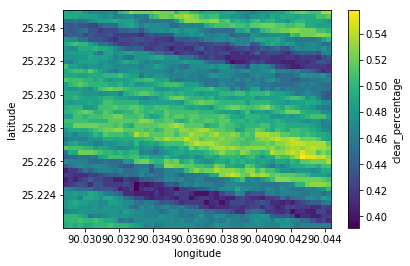

In [5]:
coverage = clear_to_total_ratio(bangladesh)
coverage.where(coverage > 0.25).plot()

## Running pyCCD on a single pixel

The first step in this process would be selecting a pixel to analyze. The following coordinates are derived from analysis of high resolution imagery on Google Earth in an area where deforestation may have happened.  
<br>

In [6]:
pixel_coordinates = {"latitude":25.228928,"longitude": 90.035790}

<br>
The coordinates above aren't exactley aligned with the coordinates of our dataset.  In the code below we select the pixel from our dataset that is closest to our `pixel_coordinates` using [nearest](http://xarray.pydata.org/en/stable/indexing.html#nearest-neighbor-lookups).  
<br>  

In [7]:
pixel = bangladesh.sel(**pixel_coordinates, method = 'nearest')

<br>  

The next step is importing our change detection utility.  
`utils.dc_ccd` is a datacube wrapper for [pyCCD](https://github.com/USGS-EROS/lcmap-pyccd).  
  
<br>

In [8]:
import utils.data_cube_utilities.dc_ccd as ccd

<br>
I process our target pixel using `ccd.process_pixel()`. This function takes a single positional argument: a 1x1 pixel dataset.   
<br>

In [9]:
ccd_proccessed_pixel = ccd.process_pixel(pixel)

DEBUG:ccd.procedures:Procedure selected: standard_procedure
DEBUG:ccd.procedures:Build change models - dates: 138, obs: (7, 138), meow_size: 12, peek_size: 6
DEBUG:ccd.procedures:Processing mask initial count: 69
DEBUG:ccd.procedures:Variogram values: [ 222.  219.  260.  456.  369.  257.    0.]
DEBUG:ccd.procedures:Initialize for change model #: 1
DEBUG:ccd.change:Initial slice(0, 12, None)
DEBUG:ccd.change:Sufficient time from times[0..15] (day #732322 to #732690)
DEBUG:ccd.change:Checking window: slice(0, 15, None)
DEBUG:ccd.change:Number of Tmask outliers found: 1
DEBUG:ccd.change:Generating models to check for stability
DEBUG:ccd.change:Stability norm: 6.33214548674, Check against: 15.086272469388987
DEBUG:ccd.change:Stable start found: slice(0, 14, None)
DEBUG:ccd.procedures:Extend change model
DEBUG:ccd.change:lookforward initial model window: slice(0, 14, None)
DEBUG:ccd.change:Detecting change for slice(14, 20, None)
DEBUG:ccd.change:Retrain models, less than 24 samples
DEBUG:c

DEBUG:ccd.change:Magnitudes of change: [  8.45057428  25.50925103  70.03431802  73.81897927  48.05940041
  88.47776909]
DEBUG:ccd.change:Detecting change for slice(53, 59, None)
DEBUG:ccd.change:Magnitudes of change: [ 25.51287175  70.03613179  73.82133321  48.06627462  88.48885269
  34.27156403]
DEBUG:ccd.change:Change detected at: 53
DEBUG:ccd.procedures:Accumulate results, 1 so far
DEBUG:ccd.change:Catching observations: slice(53, 68, None)
DEBUG:ccd.procedures:change detection complete
DEBUG:lcmap-pyccd:Total time for algorithm: 0.7467052936553955


<br> 

The function above takes our original dataset and appends ccd related attributes to your xarray that can be checked using `xarray.dataset.attrs`.  

<br>

In [10]:
ccd_proccessed_pixel.attrs.keys()

odict_keys(['crs', 'ccd_results', 'ccd_start_times', 'ccd_end_times', 'ccd_break_times', 'ccd'])

<br>

## Plotting pyCCD results  

  
Passing a pixel into the `ccd.plot` function will display time series visualizations depicting change on one or more of the bands.  

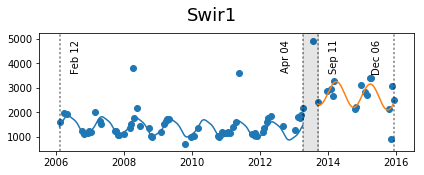

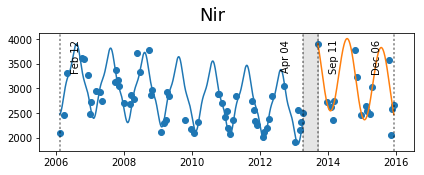

In [11]:
ccd.plot_pixel(ccd_proccessed_pixel, bands = ['swir1', 'nir'])

## Running pyCCD on a large area

The plot pixel function above is suitable for a per-pixel analysis case. The final product stores a large number of coeffiecients per pixel. Detailed below is a closed-form calculation of the number of coefficients needed per pixel.   

<br>

$$ Num_{coefficients} = 8 * Num_{bands} * (Num_{changes} + 1) $$ 

<br>

This sort of growth makes in-memory storage of coefficients infeasible for larger areas.  To combat this, Instead of storing the  coefficients of each pixel, we generate a `change_volume` product.    
  
  <br>

![img](diagrams/ccd/change_volume.png)

The `change_volume` product is the count of all `break_day` indices in a per pixel pyccd analysis.  To compute this, simply call `ccd.process_xarray()`. For for large areas, this should take a considerable amount of time to compute (2 hours for a 300x300 px swath)  
<br>

In [12]:
change_volume_bangladesh = ccd.process_xarray(bangladesh, distributed = True)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



`ccd.process_xarray()` should return an xarray data-array detailing change volume. Being an `xarray.dataarray()`, you should be able to call a plot function to visualize results  
  
<br>  


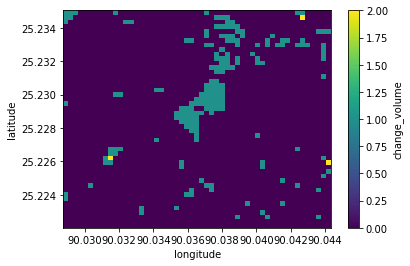

In [13]:
change_volume_bangladesh.plot()

## The  dc_ccd library

The following functions can be called from `dc_ccd`:  

- `dc_ccd.process_pixel(ds)`  
  takes a 1-by-1 dataset, computes ccd, and returns a duplicate pixel with xarray metadata appended.  
  
    
- `dc_ccd.plot_pixel(ds, bands = None)`:  
  takes a 1-by-1 dataset that has been processed by ccd and plots the time series models for that pixel.  
  This function accepts an additional parameter called bands that can be used to limit what is plotted. Simply pass in a list of   band name strings.    
  
    
- `dc_ccd.process_xarray(ds, distributed = True)`: takes a dataset and returns a change_volume product. Accepts an aditional  
   parameter called `distributed` that toggles full core-utilization/distribution of ccd processing.  


`